# Import Boundary Conditions from PINACLES and write in AMR-Wind Format

In [1]:
import numpy as np
from pathlib import Path
import h5py
import matplotlib.pyplot as plt
import os
import re
from datetime import timedelta
from scipy import interpolate
from netCDF4 import Dataset

## Extract the PINACLES file names and times from the files

In [2]:
loc = Path('/projects/oracle/pinacles_share/fields2d')

def get_seconds(filename):
    match = re.match(r"(\d{2})d-(\d{2})h-(\d{2})m-(\d{2})s-(\d{3})ms\.h5", filename)
    if match:
        d, h, m, s, ms = map(int, match.groups())
        return timedelta(days=d, hours=h, minutes=m, seconds=s, milliseconds=ms).total_seconds()

# The names of the files sorted
time_files = sorted(
        [f for f in os.listdir(loc) if f.endswith('.h5') and get_seconds(f) is not None]
    )

# time_data = {
#     f: get_seconds(f) for f in os.listdir(loc) if f.endswith('.h5') and get_seconds(f) is not None
# }

# Print results
# for fname, sec in time_data.items():
#     print(f"{fname}: {sec} seconds")

times_in_seconds = np.array([
    get_seconds(f) for f in time_files
])

print(time_files)
print(times_in_seconds)

['00d-00h-00m-00s-000ms.h5', '00d-00h-01m-00s-000ms.h5', '00d-00h-02m-00s-000ms.h5', '00d-00h-03m-00s-000ms.h5', '00d-00h-04m-00s-000ms.h5', '00d-00h-05m-00s-000ms.h5', '00d-00h-06m-00s-000ms.h5', '00d-00h-07m-00s-000ms.h5', '00d-00h-08m-00s-000ms.h5', '00d-00h-09m-00s-000ms.h5', '00d-00h-10m-00s-000ms.h5', '00d-00h-11m-00s-000ms.h5', '00d-00h-12m-00s-000ms.h5', '00d-00h-13m-00s-000ms.h5', '00d-00h-14m-00s-000ms.h5', '00d-00h-15m-00s-000ms.h5', '00d-00h-16m-00s-000ms.h5', '00d-00h-17m-00s-000ms.h5', '00d-00h-18m-00s-000ms.h5', '00d-00h-19m-00s-000ms.h5', '00d-00h-20m-00s-000ms.h5', '00d-00h-21m-00s-000ms.h5', '00d-00h-22m-00s-000ms.h5', '00d-00h-23m-00s-000ms.h5', '00d-00h-24m-00s-000ms.h5', '00d-00h-25m-00s-000ms.h5', '00d-00h-26m-00s-000ms.h5', '00d-00h-27m-00s-000ms.h5', '00d-00h-28m-00s-000ms.h5', '00d-00h-29m-00s-000ms.h5', '00d-00h-30m-00s-000ms.h5', '00d-00h-31m-00s-000ms.h5', '00d-00h-32m-00s-000ms.h5', '00d-00h-33m-00s-000ms.h5', '00d-00h-34m-00s-000ms.h5', '00d-00h-35m-00s-00

## Extract the arrays of velocity data from PINACLES in numpy format

In [3]:
# Determine the number of time steps
num_files = len(time_files)

# Open the first file to get the shape of the data arrays (assuming all files have the same shape)
with h5py.File(os.path.join(loc, time_files[0]), "r") as f:
    u_shape = f['u_x_0'].shape 
    x = np.array(f['X'])
    y = np.array(f['Y'])
    z = np.array(f['Z'])

    # Traverse the entire structure and print content
    # def print_structure(name, obj):
    #     print(f"{name}: {type(obj)}")
    # f.visititems(print_structure)
        
    # print(x)
    # print(y)
    # print(z)

# Pre-allocate the NumPy arrays for u, v, w
u_data = np.zeros((num_files, *u_shape))
v_data = np.zeros((num_files, *u_shape))
w_data = np.zeros((num_files, *u_shape))
T_data = np.zeros((num_files, *u_shape))

# Populate the arrays with data from each file
for idx, fname in enumerate(time_files):
    with h5py.File(os.path.join(loc, fname), "r") as f:
        u_data[idx] = f['u_x_0'][:]
        v_data[idx] = f['v_x_0'][:]
        w_data[idx] = f['w_x_0'][:]
        T_data[idx] = f['T_x_0'][:]

# Print shapes to verify data
print(f"u_data shape: {u_data.shape}")
print(f"v_data shape: {v_data.shape}")
print(f"w_data shape: {w_data.shape}")

u_data shape: (361, 1, 60, 150)
v_data shape: (361, 1, 60, 150)
w_data shape: (361, 1, 60, 150)


## The AMR-Wind Domain

In [4]:
# The length of the domain in the y and z direction
ylo, zlo = 10, 10
yhi, zhi = 2000, 1200

# The number of grid points out from the amr-wind sim
ny = 64 
nz = 128 

dy, dz = (yhi-ylo)/ny, (zhi-zlo)/nz

# The desired output at cell centers
y_out = np.linspace(ylo + dy/2, yhi-dy/2, ny, endpoint=True)
z_out = np.linspace(zlo + dz/2, zhi-dy/2, nz, endpoint=True)

Y, Z = np.meshgrid(y_out, z_out, indexing='ij')
# print(Y)
# print(Z)

## Create the amr-wind data by interpolating the PINACLES data

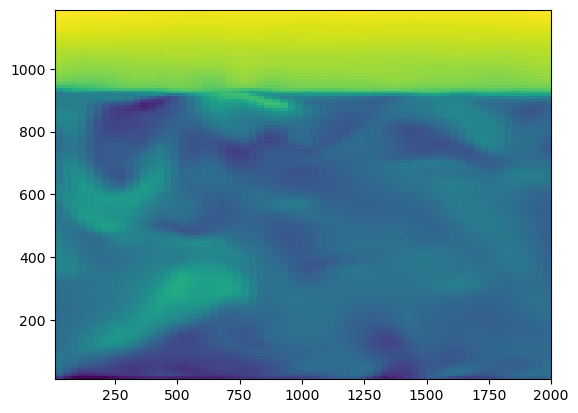

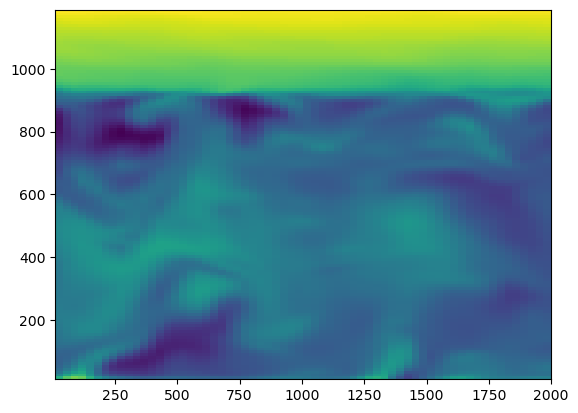

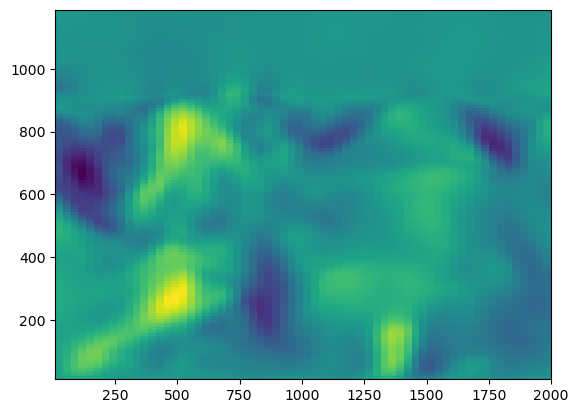

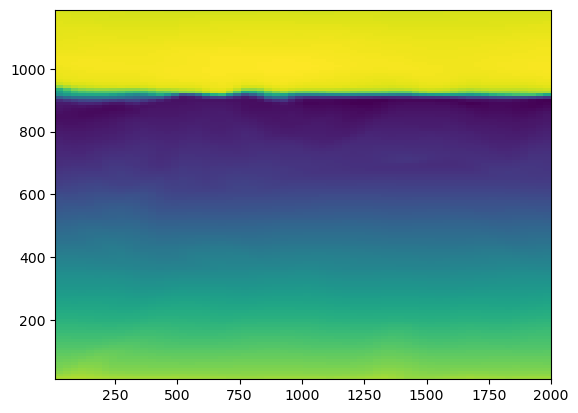

In [5]:
# Create arrays with proper dimensions and populate data with arrays
velocity_bc = np.zeros((num_files, ny, nz, 3))
temperature_bc = np.zeros((num_files, ny, nz))
tke_bc = np.ones((num_files, ny, nz)) * 0.001 # Initialize to small value

# Loop through all the times
for nt in range(num_files):

    # # Build a 2D interpolator from PINACLES data
    u_int = interpolate.RegularGridInterpolator((y, z), u_data[nt, 0, :,:], method='linear', bounds_error=False, fill_value=None)
    v_int = interpolate.RegularGridInterpolator((y, z), v_data[nt, 0, :,:], method='linear', bounds_error=False, fill_value=None)
    w_int = interpolate.RegularGridInterpolator((y, z), w_data[nt, 0, :,:], method='linear', bounds_error=False, fill_value=None)
    T_int = interpolate.RegularGridInterpolator((y, z), T_data[nt, 0, :,:], method='linear', bounds_error=False, fill_value=None)
 
    # Interpolate the data 
    velocity_bc[nt, :, :, 0] = u_int((Y, Z))
    velocity_bc[nt, :, :, 1] = v_int((Y, Z))
    velocity_bc[nt, :, :, 2] = w_int((Y, Z))
    temperature_bc[nt, :, :] = T_int((Y, Z))
    
plt.pcolormesh(Y, Z, velocity_bc[nt, :, :, 0])

plt.figure()
plt.pcolormesh(Y, Z, velocity_bc[nt, :, :, 1])

plt.figure()
plt.pcolormesh(Y, Z, velocity_bc[nt, :, :, 2])

plt.figure()
plt.pcolormesh(Y, Z, temperature_bc[nt, :, :])


# Write the netcdf file for AMR-Wind boundary conditions

In [6]:
outfile = 'bc_amr_wind.nc'

'''
This is the output file that will be saved with the 
boundary condition for amr-wind
'''
with Dataset(outfile, "w", format="NETCDF4") as rootgrp:
    ## ~~~~~~~~ Operate on the root group ~~~~~~~~
    # Add dimensions to the root group
    rootgrp.createDimension('sdim', 1)
    rootgrp.createDimension('pdim', 2)
    rootgrp.createDimension('vdim', 3)
    rootgrp.createDimension('nt', None)

    # Add groups
    grp_xlo = rootgrp.createGroup("/xlo")

    # Add variables    
    rootgrp.createVariable("time","f8",("nt",))
    rootgrp['time'][:] = times_in_seconds


    ## ~~~~~~~~ Operate on the xlo and ylo groups ~~~~~~~~
    # No need to add dimensions

    # Add groups
    grp_xlo_l0 = grp_xlo.createGroup('/level_0')

    # Add variables
    grp_xlo.createVariable("normal","i4",)
    grp_xlo.createVariable("side","i4",)
    grp_xlo.createVariable("perpendicular","i4",("pdim",))

    grp_xlo['normal'][:] = 0
    grp_xlo['side'][:] = 0
    grp_xlo['perpendicular'][:] = [1, 2]

    ## ~~~~~~~~ Operate on the xlo/level_0 and ylo/level_0 groups ~~~~~~~~
    # Add dimensions
    grp_xlo_l0.createDimension('nx', 1)
    grp_xlo_l0.createDimension('ny', ny)
    grp_xlo_l0.createDimension('nz', nz)

    # Add variables
    grp_xlo_l0.createVariable("lengths","f8",("pdim",))
    grp_xlo_l0.createVariable("lo","f8",("pdim",))
    grp_xlo_l0.createVariable("hi","f8",("pdim",))
    grp_xlo_l0.createVariable("dx","f8",("pdim",))
    grp_xlo_l0.createVariable("velocity","f8",("nt", "ny", "nz", "vdim",))
    grp_xlo_l0.createVariable("temperature","f8",("nt", "ny", "nz",))
    grp_xlo_l0.createVariable("tke","f8",("nt", "ny", "nz",))  # TODO: Am I precribing SGS TKE correctly?

    print(velocity_bc.shape)
    grp_xlo_l0['lengths'][:] = [yhi, zhi]
    grp_xlo_l0['lo'][:] = [ylo, zlo]
    grp_xlo_l0['hi'][:] = [yhi, zhi]
    grp_xlo_l0['dx'][:] = [dy, dz]
    grp_xlo_l0['velocity'][:] = velocity_bc
    grp_xlo_l0['temperature'][:] = temperature_bc
    grp_xlo_l0['tke'][:] = tke_bc

    print(grp_xlo_l0['velocity'])

(361, 64, 128, 3)
<class 'netCDF4._netCDF4.Variable'>
float64 velocity(nt, ny, nz, vdim)
path = /xlo/level_0
unlimited dimensions: nt
current shape = (361, 64, 128, 3)
filling on, default _FillValue of 9.969209968386869e+36 used
